# 1. Import packages

In [5]:
import pickle
from keras.layers import Dense, Input, Flatten, merge, LSTM, GRU, Dropout, Bidirectional, Conv1D, \
                            MaxPooling1D, Embedding, GlobalAveragePooling1D, TimeDistributed
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Hyperparameters and user-inputs

In [2]:
VAL_SPLIT = 0.05
MAX_SEQ_LEN = 50

NUM_EPOCHS = 30
BATCH_SIZE = 48

LSTM_OUT_SIZE = 64

# 3. Load data and embedding

In [3]:
with open('PreparedData/train.pkl', 'rb') as f:
    X_train_seq1, X_train_seq2, y_train = pickle.load(f)
    
with open('PreparedData/test.pkl', 'rb') as f:
    X_test_seq1, X_test_seq2, y_test = pickle.load(f)
    
with open('SavedObjects/embedding.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

# 4. Train a model

## 4.1. Design model

In [4]:
embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], input_length=MAX_SEQ_LEN,
                            weights=[embedding_matrix], trainable=False)

### Model 1

In [5]:
sequence_1_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = Conv1D(128, 3, activation='relu')(embedded_sequences_1)
x1 = MaxPooling1D(10)(x1)
x1 = Flatten()(x1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dropout(0.2)(x1)

sequence_2_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = Conv1D(128, 3, activation='relu')(embedded_sequences_2)
y1 = MaxPooling1D(10)(y1)
y1 = Flatten()(y1)
y1 = Dense(64, activation='relu')(y1)
y1 = Dropout(0.2)(y1)

merged = merge([x1,y1], mode='concat')
merged = BatchNormalization()(merged)
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)

model = Model(input=[sequence_1_input,sequence_2_input], output=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
# val_acc=64.07 after 10 epochs

/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rakesh47/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      15000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 48, 128)      115328      embedding_1[0][0]                
__________

### Model 2. Increased dropout

In [5]:
sequence_1_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = Conv1D(128, 3, activation='relu')(embedded_sequences_1)
x1 = MaxPooling1D(10)(x1)
x1 = Flatten()(x1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dropout(0.5)(x1)

sequence_2_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = Conv1D(128, 3, activation='relu')(embedded_sequences_2)
y1 = MaxPooling1D(10)(y1)
y1 = Flatten()(y1)
y1 = Dense(64, activation='relu')(y1)
y1 = Dropout(0.5)(y1)

merged = merge([x1,y1], mode='concat')
merged = BatchNormalization()(merged)
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)

model = Model(input=[sequence_1_input,sequence_2_input], output=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
# val_acc=64.20 after 10 epochs

/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rakesh47/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      15000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 48, 128)      115328      embedding_1[0][0]                
__________

### Model 3. GlobalAveragePooling

In [5]:
sequence_1_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = GlobalAveragePooling1D()(embedded_sequences_1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dropout(0.5)(x1)

sequence_2_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = GlobalAveragePooling1D()(embedded_sequences_2)
y1 = Dense(64, activation='relu')(y1)
y1 = Dropout(0.5)(y1)

merged = merge([x1,y1], mode='concat')
merged = BatchNormalization()(merged)
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)

model = Model(input=[sequence_1_input,sequence_2_input], output=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
# val_acc=70.66 after 10 epochs

/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
/home/rakesh47/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      15000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 300)          0           embedding_1[0][0]                
__________

### Model 4. GlobalAveragePooling. Reduced dropout

In [5]:
sequence_1_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = GlobalAveragePooling1D()(embedded_sequences_1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dropout(0.25)(x1)

sequence_2_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = GlobalAveragePooling1D()(embedded_sequences_2)
y1 = Dense(64, activation='relu')(y1)
y1 = Dropout(0.25)(y1)

merged = merge([x1,y1], mode='concat')
merged = BatchNormalization()(merged)
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.25)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)

model = Model(input=[sequence_1_input,sequence_2_input], output=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
# val_acc=74.51 after 30 epochs. Train longer

/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
/home/rakesh47/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      15000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 300)          0           embedding_1[0][0]                
__________

### Model 5. GlobalAveragePooling. Reduced dense units

In [5]:
sequence_1_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = GlobalAveragePooling1D()(embedded_sequences_1)
x1 = Dense(48, activation='relu')(x1)
x1 = Dropout(0.25)(x1)

sequence_2_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = GlobalAveragePooling1D()(embedded_sequences_2)
y1 = Dense(48, activation='relu')(y1)
y1 = Dropout(0.25)(y1)

merged = merge([x1,y1], mode='concat')
merged = BatchNormalization()(merged)
merged = Dense(48, activation='relu')(merged)
merged = Dropout(0.25)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)

model = Model(input=[sequence_1_input,sequence_2_input], output=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
# val_acc=73.71 after 30 epochs. Train longer

/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
/home/rakesh47/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      15000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 300)          0           embedding_1[0][0]                
__________

### Model 6. GlobalAveragePooling. Reduced dense units further

In [5]:
sequence_1_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = GlobalAveragePooling1D()(embedded_sequences_1)
x1 = Dense(32, activation='relu')(x1)
x1 = Dropout(0.25)(x1)

sequence_2_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = GlobalAveragePooling1D()(embedded_sequences_2)
y1 = Dense(32, activation='relu')(y1)
y1 = Dropout(0.25)(y1)

merged = merge([x1,y1], mode='concat')
merged = BatchNormalization()(merged)
merged = Dense(32, activation='relu')(merged)
merged = Dropout(0.25)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)

model = Model(input=[sequence_1_input,sequence_2_input], output=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
# val_acc=72.74 after 30 epochs. Train longer.

/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
/home/rakesh47/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      15000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 300)          0           embedding_1[0][0]                
__________

### Model 7. LSTM

In [31]:
sequence_1_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = LSTM(LSTM_OUT_SIZE, dropout=0.25, recurrent_dropout=0.25)(embedded_sequences_1)
x1 = Dense(32, activation='relu')(x1)
x1 = Dropout(0.25)(x1)

sequence_2_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = LSTM(LSTM_OUT_SIZE, dropout=0.25, recurrent_dropout=0.25)(embedded_sequences_2)
y1 = Dense(32, activation='relu')(y1)
y1 = Dropout(0.25)(y1)

merged = merge([x1,y1], mode='concat')
merged = BatchNormalization()(merged)
merged = Dense(32, activation='relu')(merged)
merged = Dropout(0.25)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)

model = Model(input=[sequence_1_input,sequence_2_input], output=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
# val_acc=76.00 after 10 epochs. Train longer.

/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
/home/rakesh47/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      15000300    input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 64)           93440       embedding_1[9][0]                
__________

### Model 8. Bidirectional LSTM

In [5]:
sequence_1_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = Bidirectional(LSTM(int(LSTM_OUT_SIZE/2), dropout=0.25, recurrent_dropout=0.25))(embedded_sequences_1)
x1 = Dense(32, activation='relu')(x1)
x1 = Dropout(0.25)(x1)

sequence_2_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = Bidirectional(LSTM(int(LSTM_OUT_SIZE/2), dropout=0.25, recurrent_dropout=0.25))(embedded_sequences_2)
y1 = Dense(32, activation='relu')(y1)
y1 = Dropout(0.25)(y1)

merged = merge([x1,y1], mode='concat')
merged = BatchNormalization()(merged)
merged = Dense(32, activation='relu')(merged)
merged = Dropout(0.25)(merged)
merged = BatchNormalization()(merged)
preds = Dense(1, activation='sigmoid')(merged)

model = Model(input=[sequence_1_input,sequence_2_input], output=preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
# val_acc=74.41 after 4 epochs. Train longer.

/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
/home/rakesh47/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rakesh47/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      15000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           85248       embedding_1[0][0]                
__________

## 4.2. Train the model

In [6]:
model_path = 'Models/model6.h5'
cb = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True)
history = model.fit([X_train_seq1, X_train_seq2], y_train, validation_split=VAL_SPLIT,
          epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[cb])

Train on 328381 samples, validate on 17284 samples
Epoch 1/30
328381/328381 [==============================] - 52s 158us/step - loss: 0.6473 - acc: 0.6323 - val_loss: 0.5944 - val_acc: 0.6846
Epoch 2/30
328381/328381 [==============================] - 51s 155us/step - loss: 0.6335 - acc: 0.6458 - val_loss: 0.5765 - val_acc: 0.7042
Epoch 3/30
328381/328381 [==============================] - 51s 154us/step - loss: 0.6307 - acc: 0.6493 - val_loss: 0.5829 - val_acc: 0.7151
Epoch 4/30
328381/328381 [==============================] - 50s 154us/step - loss: 0.6281 - acc: 0.6524 - val_loss: 0.5785 - val_acc: 0.6910
Epoch 5/30
328381/328381 [==============================] - 51s 156us/step - loss: 0.6271 - acc: 0.6531 - val_loss: 0.5748 - val_acc: 0.7009
Epoch 6/30
328381/328381 [==============================] - 49s 149us/step - loss: 0.6254 - acc: 0.6547 - val_loss: 0.5706 - val_acc: 0.7112
Epoch 7/30
328381/328381 [==============================] - 49s 150us/step - loss: 0.6246 - acc: 0.6564

# 5. Evaluate the trained model

In [7]:
model = load_model(model_path)
score = model.evaluate([X_test_seq1, X_test_seq2], y_test)
print('\nTest loss: ', score[0])
print('Test accuracy: ', score[1])

/home/rakesh47/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1269: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


18194/18194 [==============================] - 1s 71us/step

Test loss:  0.555185124234
Test accuracy:  0.72743761679


In [8]:
y_predicted = model.predict([X_test_seq1, X_test_seq2])
print("ROC-AUC score: %f" %(roc_auc_score(y_test, y_predicted)))

ROC-AUC score: 0.797258


# 6. Plot 'accuracy' and 'loss' curves

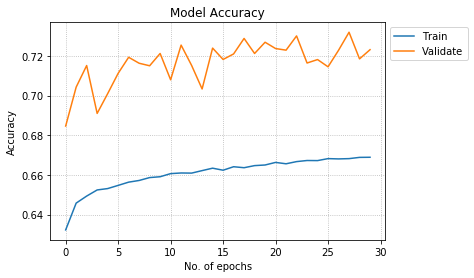

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of epochs')
plt.grid(linestyle='dotted')
lgd = plt.legend(['Train', 'Validate'], bbox_to_anchor=(1, 1), loc=2)
plt.show()

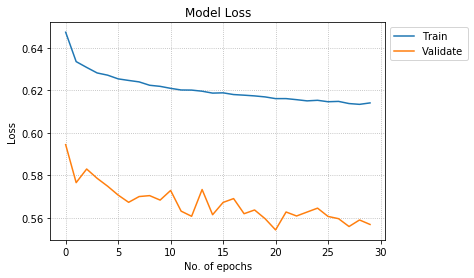

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of epochs')
plt.grid(linestyle='dotted')
lgd = plt.legend(['Train', 'Validate'], bbox_to_anchor=(1, 1), loc=2)
plt.show()